# Remoção de ruídos de documentos utilizando Auto Encoder Convolucional

### Imports necessários

In [8]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.callbacks import TensorBoard
from keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize,rescale
from os import listdir

from IPython.display import Image

### Função para carregar e montar os dados em memória para realizar o treinamento

Como nossos dados são imagens salvas no disco, precisamos de uma função customizada

In [2]:
def build_data():
    
    x_train = []
    
    for file in listdir('kdd/train'):
    
        img = imread('kdd/train/' + file)
        
        img = resize(img,(260,540),True)
        
        img = img.reshape(1,img.shape[0],img.shape[1])
    
        
        x_train.append(img)
        
    
    x_train = tuple(x_train)
    
    x_train = np.concatenate(x_train)
    
    y_train = [] 
    
    
    for file in listdir('kdd/train_cleaned'):
    
        img = imread('kdd/train_cleaned/' + file)
        
        img = resize(img,(260,540),True)
        
        y_train.append(img.reshape(1,img.shape[0],img.shape[1]))
    
    
    
    y_train = tuple(y_train)
    
    y_train = np.concatenate(y_train)
    
    x_test = []
    
    for file in listdir('kdd/test'):
    
        img = imread('kdd/test/' + file)
        
        img = resize(img,(260,540),True)
        
        x_test.append(img.reshape(1,img.shape[0],img.shape[1]))
    
    
    
    x_test = tuple(x_test)
    
    x_test = np.concatenate(x_test)
    
    return x_train,y_train,x_test
    


In [3]:
x_train, y_train, x_test = build_data()

In [4]:
x_train = np.reshape(x_train, (len(x_train), 260, 540, 1))
y_train = np.reshape(y_train, (len(x_train), 260, 540, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 260, 540, 1))  # adapt this if using `channels_first` image data format

In [5]:
x_validation = x_train[121:145]
x_train = x_train[0:120]

y_validation = y_train[121:145]
y_train = y_train[0:120]

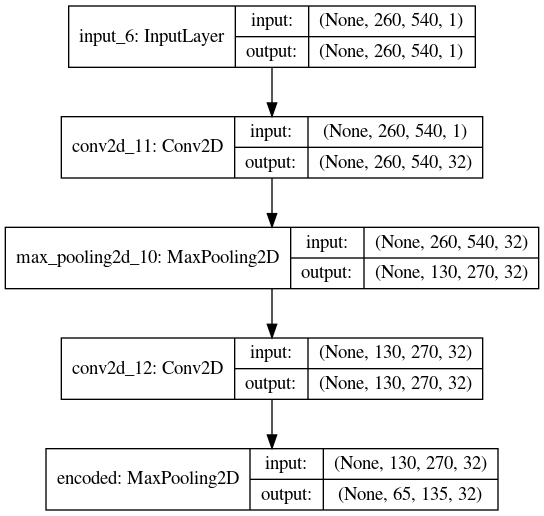

In [12]:
input_img = Input(shape=(260,540,1))

downConv = Conv2D(32,(3,3),activation='relu',padding='same')(input_img)
downConv = MaxPooling2D((2,2),padding='same')(downConv)
downConv = Conv2D(32,(3,3),activation='relu',padding='same')(downConv)

encoded = MaxPooling2D((2,2),padding='same',name='encoded')(downConv)

encoder = Model(input_img,encoded,name='encoder')

plot_model(encoder, to_file='cae_encoder.png',show_shapes=True)

Image(retina=False, filename='cae_encoder.png',width=535,height=516)

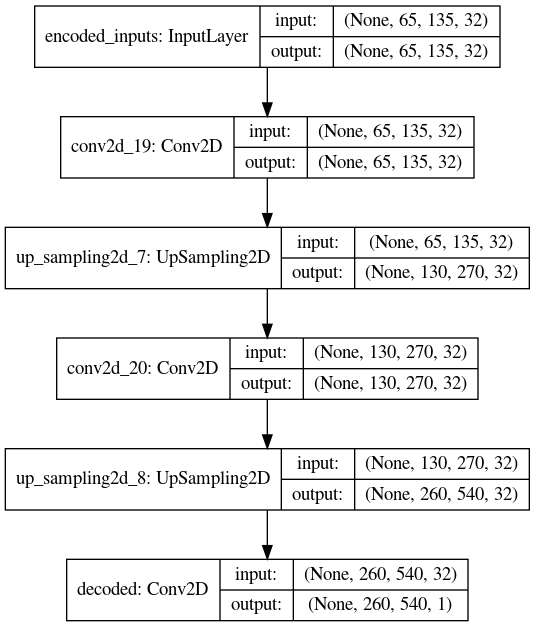

In [16]:
encoded_inputs = Input(shape=(65,135,32), name='encoded_inputs')
upConv = Conv2D(32,(3,3),activation='relu',padding='same')(encoded_inputs)
upConv = UpSampling2D((2,2))(upConv)
upConv = Conv2D(32,(3,3),activation='relu',padding='same')(upConv)
upConv = UpSampling2D((2,2))(upConv)


decoded = Conv2D(1,(3,3), activation='sigmoid', padding='same',name='decoded')(upConv)

decoder = Model(encoded_inputs,decoded,name='decoder')

plot_model(decoder, to_file='cae_decoder.png',show_shapes=True)

Image(retina=False, filename='cae_decoder.png',width=535,height=516)

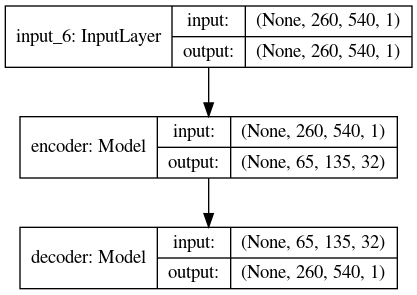

In [17]:
outputs = decoder(encoder(input_img))

autoencoder = Model(input_img,outputs,name='autoencoder')

plot_model(autoencoder, to_file='cae.png',show_shapes=True)

Image(retina=False, filename='cae.png',width=535,height=516)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 260, 540, 1)       0         
_________________________________________________________________
encoder (Model)              (None, 65, 135, 32)       9568      
_________________________________________________________________
decoder (Model)              (None, 260, 540, 1)       18785     
Total params: 28,353
Trainable params: 28,353
Non-trainable params: 0
_________________________________________________________________
Train on 120 samples, validate on 23 samples
Epoch 1/100
120/120 [==============================] - 3s 25ms/step - loss: 0.5143 - val_loss: 0.3430
Epoch 2/100
120/120 [==============================] - 1s 8ms/step - loss: 0.3777 - val_loss: 0.3357
Epoch 3/100
120/120 [==============================] - 1s 8ms/step - loss: 0.3575 - val_loss: 0.3239
Epoch 4/100
120/120 [==============================] 

Epoch 74/100
120/120 [==============================] - 1s 8ms/step - loss: 0.1520 - val_loss: 0.1394
Epoch 75/100
120/120 [==============================] - 1s 8ms/step - loss: 0.1516 - val_loss: 0.1385
Epoch 76/100
120/120 [==============================] - 1s 8ms/step - loss: 0.1513 - val_loss: 0.1383
Epoch 77/100
120/120 [==============================] - 1s 8ms/step - loss: 0.1510 - val_loss: 0.1386
Epoch 78/100
120/120 [==============================] - 1s 8ms/step - loss: 0.1507 - val_loss: 0.1375
Epoch 79/100
120/120 [==============================] - 1s 8ms/step - loss: 0.1504 - val_loss: 0.1374
Epoch 80/100
120/120 [==============================] - 1s 8ms/step - loss: 0.1503 - val_loss: 0.1374
Epoch 81/100
120/120 [==============================] - 1s 8ms/step - loss: 0.1501 - val_loss: 0.1372
Epoch 82/100
120/120 [==============================] - 1s 8ms/step - loss: 0.1497 - val_loss: 0.1368
Epoch 83/100
120/120 [==============================] - 1s 8ms/step - loss: 0.1493

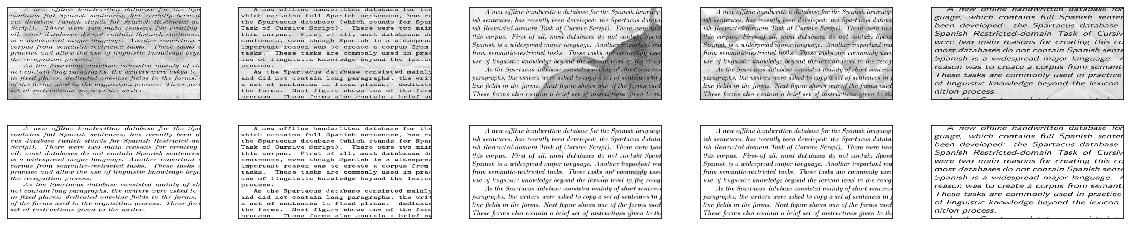

In [18]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

autoencoder.fit(x_train, y_train,
                epochs=100,
                batch_size=12,
                shuffle=True,
                validation_data=(x_validation, y_validation))


In [ ]:
denoised_imgs = autoencoder.predict(x_test)

n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(260, 540))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(denoised_imgs[i].reshape(260, 540))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.show()
plt.savefig('kdd_result.png')

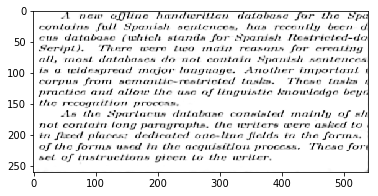

In [19]:
plt.imshow(denoised_imgs[0].reshape(260, 540))

In [20]:
plt.imsave('test.png', denoised_imgs[0].reshape(260, 540))